### Particle Image Velocimetry (PIV)
##### Year 3 Project Code - Kavya Karnati - 2087138

Introduction:

PIV is popular optical particle-based imaging technique to analyse the flow dynamics and patterns of fluids, seeded with tracer particles. The technique is a key tool in collecting quantitative data, such as velocity, displacment in x and y direction and acceleration, as well as qualitative data, such as streamline plots, heatmaps and quiver plots. In its simplest form, the stages of PIV follows experimental seeding, imaging of the system, post-processing of the illuminations and then data analysis. 

The following code accepts input, in the form of a file of TIFF images, of the experimental system containing tracer beads and uses the cross-correlation algorithm to calculate displacements between frames. For each two frames, the average of each value is calculated and recorded. 

User Instructions:

The following code can be modified and applied to experimental images by selecting the designated folder that contains the tracer-particle seeded illuminations. Also, the following conditions can be altered to optimise the results: size of the interrogation window, size of search window, number of correlation cycles, maximum correlation co-efficient and the spatial and time scale. However, it is reccommeneded to keep these parameters the same as the present values. 

1. Import libraries for PIV

In [4]:
#import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm 
from numba import jit 
from joblib import Parallel, delayed
import os
import pandas as pd
import pims
from PIL import Image

In [5]:
#import extensions for matplotlib
import matplotlib as mpl
%matplotlib widget
from ipywidgets import interact, interactive, fixed #Sliders for image selection
import ipywidgets as widgets
mpl.rc('figure',  figsize=(4.77, 2.95))
mpl.rc('font', family='serif')
plt.rc('grid', linestyle="--", color='gray')
mpl.rc('image', cmap='gray')

2. Define main PIV functions

Firstly, the corr2 function calculates the normalised cross-correlation coefficient between the two interrogation windows, c1 and c2. This value is a measure of the similarity, correlation, between two windows of consecutive frames and is crucial for determining the displacement between the ensemble of tracer particle patterns in the windows. This function is called in the main PIV algorithm, in which cross-correlation between two subareas of the two images is computed and stored in a correlation matrix R. In this function, an important step is to check if the result is 0, to avoid divisions with 0.

In [6]:
#cross-correlation function

@jit(nopython=True) #improve speed of calculations
def corr2(c1,c2): 
    c1-=c1.mean() #subtract mean from each interrogation windows c1 and c2
    c2-=c2.mean()
    c12=(c1*c1).sum()*(c2*c2).sum() #calculate the product of squared values of images 
    if c12>0.0: #check if value to avoid division with 0
        return (c1*c2).sum()/np.sqrt(c12)
    return -1.0

Secondly, the fixer function corrects any irregular vectors produced from the main PIV algorithm. Irregular vectors are detected by relatively low correlation coefficients, below the determined threshold, and could be a result of noise or rapid movement due to external impact. 

The function requires the following input parameters, which are defined in the main PIV algorithm:

- vecx: the x-displacement of the vectors
- vecy: the y-displacement of the vectors
- vec: the magnitude of the vectors
- rij: the correlation coefficients
- r_limit: a threshold for the correlation coefficient
- i_fix: the maximum number of correction cycles

It works through calculating the normalised fluccuations by comparing each vector with neighbouring vectors to identify deviations in the data. PIV relies on the assumption that ensembles of tracer particles follow similar patterns of flow, and therefore a large disrepancy in the vector indicates misjudgment of the algorithm. 

Then, the function identifies fluccuations above the threshold or correlation coefficients below the threshold and performs corrections using a bilinear fix. The bilinear fix uses the average of the neighbouring vectors. As a default setting, the paramters for the threshold is 2.0 for fluccuation and 0.5 for correlation coefficient. This threshold was chosen to minimize the impact of both false negatives and false positives, to strike a balance between sensitivity and specificity. 

In [7]:
#fixer function 

def fixer(vecx,vecy,vec,rij,r_limit,i_fix): 
    
    fluc=np.zeros(vec.shape) #define fluccuations array with zeros using the size of vec 
    
    for j in range(1,vec.shape[1]-1):  #iterate through columns and rows 
        for i in range(1,vec.shape[0]-1):
            
            neigh_x=np.array([]) #define empty array to store neighbour vectors for x and y 
            neigh_y=np.array([])
            
            for ii in range(-1,2):  
                for jj in range(-1,2):
                    if ii==0 and jj==0: continue #skip current vector 
                    
                    neigh_x=np.append(neigh_x,vecx[i+ii,j+jj]) #append neighbourhood x and y vectors 
                    neigh_y=np.append(neigh_y,vecy[i+ii,j+jj])
            
            res_x=neigh_x-np.median(neigh_x) #calculate residuals for x and y  
            res_y=neigh_y-np.median(neigh_y)
            
            #normalise residuals using median of the mod residual value
            res_s_x=np.abs(vecx[i,j]-np.median(neigh_x))/(np.median(np.abs(res_x))+0.1) 
            res_s_y=np.abs(vecy[i,j]-np.median(neigh_y))/(np.median(np.abs(res_y))+0.1)
            
            #calculate normalised fluccuations by combining normalised residuals 
            #describes how different the vector is from neighbouring vector
            fluc[i,j]=np.sqrt(res_s_x*res_s_x+res_s_y*res_s_y)
    
    
    i_disorder=0
    for ii in range(i_fix): #correlation cycles, determined by number of maximum correlation cycles
        
        i_disorder=0 
        vec_diff=0.0
        
        for j in range(1,vec.shape[1]-1): #iterate through columns and rows
            for i in range(1,vec.shape[0]-1):

                #check if normalised fluccuation is greater than 2 (too high)
                # or check if correlation is lower the corr threshold (too low) 
                if fluc[i,j]>2.0 or (rij[i,j]<r_limit): 
                    
                    i_disorder+=1 #increase count

                    #bilinear fix
                    vecx[i,j]=0.25*(vecx[i+1,j]+vecx[i-1,j]+vecx[i,j+1]+vecx[i,j-1])
                    vecy[i,j]=0.25*(vecy[i+1,j]+vecy[i-1,j]+vecy[i,j+1]+vecy[i,j-1])

                    #calculate squared difference between original vecs and corrected vecs
                    vec_diff+=(vec[i,j]-np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j]))**2.0
                    
                    #update vec magnitude at current position
                    vec[i,j]=np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j])
                    
        if i_disorder==0 or vec.mean()==0.0: break #break loop if correction is not required (no irregular vectors)
        correction_residual=vec_diff/(i_disorder*np.abs(vec.mean())) #corr residual to indicate degree of vector changes
        
        if correction_residual<1.0e-20: break #break if algorithm converges - no need for more corrections
    if ii==i_fix-1: print("Maximum correction iteration was reached!")
    
    return vecx,vecy,vec,i_disorder,ii

The third function is the subpixel resolution function, which aims to improve the calculated displacement vectors by using a parabolid-Gaussian fit to the correlation matrix. In digital processing, subpixel resolution is a common algorithm for enhancing the resolution of images. This is useful for particle tracking within fast-recorded image. 

For a given correlation matrix and axis, the subpix function estimates the subpixel displacement. It works by finding the maximum correlation value and its corresponding position on the correlation matrix. The following code is a simplified approach that approximates Gaussian fit by assuming a prabolic relationship between the natural logarithm of the peak correlation values and the neighbouring correlation values of the correlation matrix R. 

In [9]:
#estimate subpixel resolution in algorithm using (parabolic-Gaussian fit)

def subpix(R,axis): 

    dum=np.floor(np.argmax(R)/R.shape[0])  #find row index of max value in R

    R_x=int(dum) #row index of max value - vecy displacment 
    R_y=int(np.argmax(R)-dum*R.shape[0])  #row index of max value - vecx displacment 
    
    r=R[R_x,R_y] #find max value in R 

    if np.abs(r-1.0)<0.01: return 0.0 #return 0 if corr is close to 1 (no subpixel shift)

    try: #handle out-of-bounds indices

        if axis == 'y': 
            r_e=R[R_x+1,R_y] #indices for vecy
            r_w=R[R_x-1,R_y]

        else:          
            r_e=R[R_x,R_y+1] #indices for vecx
            r_w=R[R_x,R_y-1]

       
        #use Gaussian, if possible, to resolves pick locking
        if r_e>0.0 and r_w>0.0 and r>0.0: #check if max corr value r and neighbour r values are positive
            r_e=np.log(r_e) #calculate natural logs
            r_w=np.log(r_w)
            r=np.log(r)

        if (r_e+r_w-2*r)!=0.0: #checks if parabolic fitting of corr values does not equal 0 
        
            if np.abs((r_w-r_e)/(2.0*(r_e+r_w-2*r)))<1.0 and np.abs(r_e+1)>0.01 and np.abs(r_w+1)>0.01:
                
                return (r_w-r_e)/(2.0*(r_e+r_w-2*r)) #subpixel shift based on parabolic fit

        return 0.0 #if parabolic fit is not possible

    except:
        return 0.0

The next function is to crop the experimental images. This step is important to ensure that the PIV algorithm does only analyses interrogation windows containing tracer particles. This function uses the package Python PIL to perform its task.

In [10]:
#crop images
def crop_images(source_dir, dest_dir, crop_coordinates):

    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for filename in os.listdir(source_dir): #loop through files in dir
        file_path = os.path.join(source_dir, filename)

        #check if file is tiff file 
        if os.path.isfile(file_path) and filename.lower().endswith(('.tif')):

            #crop image using PIL image module
            with Image.open(file_path) as img:
                cropped_img = img.crop(crop_coordinates) #use crop_coordinates determined in main algorithm
                cropped_img.save(os.path.join(dest_dir, filename))

2. Create empty dataframe to store results

In [57]:
#create empty dataframe to store calculations
results_df = pd.DataFrame(columns=['vecx', 'vecy', 'vec', 'rij'])

3. Import and process experimental images 

In [11]:
#define path for image folder
folder_path = "images_test"

#create list of image names
file_list = os.listdir(folder_path)

#sort images in chronological order
file_list.sort()

#check number of images
print(f"Number of Frames: {len(file_list)}")

Number of Frames: 6


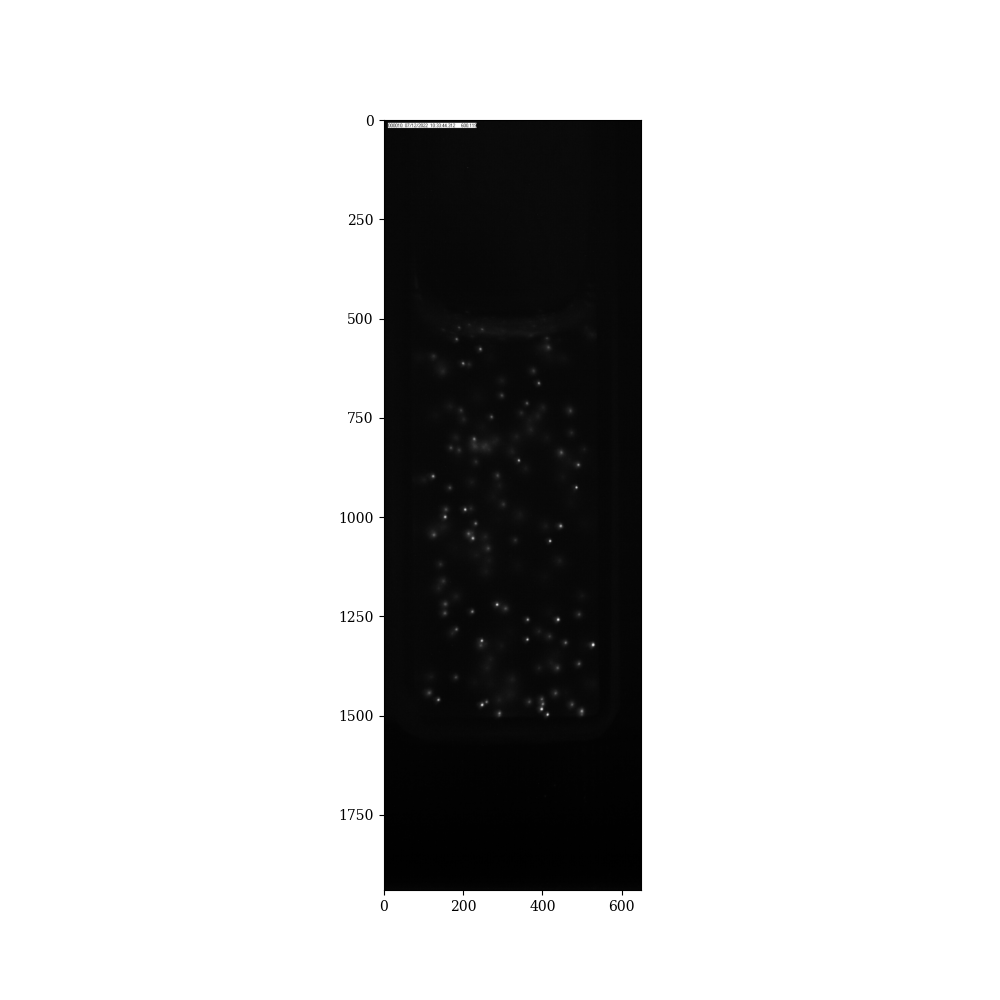

In [12]:
#import .tif images into the frames variable
frames = pims.ImageSequence(folder_path + "/*.tif")

#display one frame, with coordinates 
plt.figure(figsize=(10,10))
plt.imshow(frames[-1])

def select_frame(frame_no):
    plt.imshow(frames[frame_no])

In [13]:
#enter coordinates of the tracer particle region to eliminate empty regions
#x1, y1 = top left 
#x2, y2 = bottom right

x1 = int(input("first x coordinate")) 
y1 = int(input("first y coordinate"))
x2 = int(input("second x coordinate"))
y2 = int(input("second y coordinate"))

ValueError: invalid literal for int() with base 10: ''

In [7]:
#crop images and reupload them into new folder

if __name__ == "__main__":
    source_directory = folder_path
    destination_directory = "cropped_images" #new folder
    
    #crop with defined coordinates
    crop_coords = (x1, y1, x2, y2)

    crop_images(source_directory, destination_directory, crop_coords)

NameError: name 'folder_path' is not defined

In [13]:
#update folder path to cropped images, list and sort files

folder_path = "cropped_images"
file_list = os.listdir(folder_path)
file_list.sort()

In [65]:
#reload images to view frames 
frames = pims.ImageSequence(folder_path + "/*.tif")
%matplotlib inline

#use ipywidgets to display the frames with a slider
interact(select_frame, frame_no=widgets.IntSlider(min=0,max=len(frames)-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='frame_no', max=5), Output()), _dom_classes=('widget-inte…

<function __main__.select_frame(frame_no)>

4. Main PIV algorithm

In [14]:
#set parameters

i_fix=500     # Number of maximum correction cycles
r_limit=0.5   # minimum acceptable correlation coefficient
l_scale=1.0   # spatial scale [m/pixel]
t_scale=1.0   # time step = 1/frame_rate [s/frame]

In [15]:
#set interrogation and search window parameters 

iw=51 # Interrodation Windows Sizes (pixel)
sw=81 # Search Windows Sizes (sw > iw) (pixel)

The following cell performs the search algorithm for the PIV analysis, in which the cross-correlation algorithm is used to calculate the x-displacement, y-displacement, magnitude, and correlation coefficients. The outer for loop goes through the file of experimental images, taking two consecutive frames at a time, and then the average values of all the sub-areas of the frame is calculated and stored in the results dataframe. To optimise the code, parallelisation of the code was done using the joblib libraries 'Parallel' and 'delayed' functions. 

The x and y displacment components form the 2-dimensional displacment vector, of which the magnitude over time is the velocity. The code computes this magnitude using the Pythagorean theorem:

$ \text{magnitude} = \sqrt{ (\text{x-displacement})^2 + (\text{y-displacement})^2 } $

$ \text{velocity} = \frac{\text{magnitude}}{\Delta t} $

This formula calculates the Euclidean distance between the points in the first image and second image, per interrogation window. Overall, the movement of the tracer particles in the x and y directions are used to calculate the magnitude.

In [17]:
for i in range(0, len(file_list)-1, 1): #iterate through pairs of consecutive images

    #load two consecutive frames at a time
    img_1 = (np.flip(cv2.imread(os.path.join(folder_path, file_list[i]), 0), 0)).astype('float32')
    img_2 = (np.flip(cv2.imread(os.path.join(folder_path, file_list[i+1]), 0), 0)).astype('float32')

    #define no. of parallel jobs: 1 = no parallel processing ; 2 and above = number of parallel processes ; -1 = maximum
    cores=-1 

    #search algorithm
    ia,ja = img_1.shape  #define dimensions of first image
    iw=int(2*np.floor((iw+1)/2)-1) #check if the windows are odd numbers
    sw=int(2*np.floor((sw+1)/2)-1)
    margin=int((sw-iw)/2) #calculate margin between iw and sw

    #calculate number of interrogation windows to divide image into
    im=int(2*np.floor((ia-1-iw)/(iw-1))) # x direction
    jm=int(2*np.floor((ja-1-iw)/(iw-1))) # y direction

    #create empty arrays array of zeros with dimensions (im, jm) 
    vecx=np.zeros((im,jm)) # x-Displacement
    vecy=np.zeros((im,jm)) # y-Displacement
    vec=np.zeros((im,jm)) # Magnitude
    rij=np.zeros((im,jm)) # Correlation coeff.

    def vec_calc(j): 

        #initialise arrays for each row
        ivecx=np.zeros(im) # x-Displacement
        ivecy=np.zeros(im) # y-Displacement
        ivec=np.zeros(im)  # Magnitude
        irij=np.zeros(im)  # Correlation coeff.
    
        #calculate bounds, row/col limits for iw and sw
        j_d=int(j*(iw-1)/2) # Bottom bound
        j_u=j_d+iw          # Top bound
        sw_d=max(0,j_d-margin) # First Row
        sw_d_diff=max(0,j_d-margin)-(j_d-margin) #difference
        sw_u=min(ja-1,j_u+margin) # Last Row
    
        #iterate though iw in x direction
        for i in range(im):
            i_l=int(i*(iw-1)/2) # Left bound
            i_r=i_l+iw          # Right bound
            sw_l=max(0,i_l-margin) # First column
            sw_l_diff=max(0,i_l-margin)-(i_l-margin)
            sw_r=min(ia-1,i_r+margin) # Last column

            #initialise correlation matrix
            R=np.zeros((sw-iw+1,sw-iw+1))-1 
            c1=np.array(img_1[i_l:i_l+iw,j_d:j_d+iw]) #iw from 1st image
            
            #iterate through sw in x and y directions
            for jj in range(sw_d,sw_u+1-iw):
                for ii in range(sw_l,sw_r+1-iw):
                    c2=np.array(img_2[ii:ii+iw,jj:jj+iw]) #iw rom second image
                    R[ii-sw_l,jj-sw_d]=corr2(c1,c2) #calculate corr coeff for each pair of windows

            irij[i]=R.max() #max corr coeff for each row

            if irij[i]>=r_limit:
                dum=np.floor(np.argmax(R)/R.shape[0]) #find row with max coeff
                ivecy[i]=dum-(margin-sw_l_diff)+subpix(R,'y') #calculate y-displacement w subpixel resolution
                ivecx[i]=np.argmax(R)-dum*R.shape[0]-(margin-sw_d_diff)+subpix(R,'x') #calculate x-displacement w subpixel resolution
                ivec[i]=np.sqrt(ivecx[i]*ivecx[i]+ivecy[i]*ivecy[i]) #calculate magnitude (velocity)
            
            else:
                ivecx[i]=0.0;ivecy[i]=0.0;ivec[i]=0.0 

        return j,ivec, ivecx, ivecy, irij
        
    #perform vec_calc function for all rows in parallel   
    reconst = Parallel(n_jobs=cores)(delayed(vec_calc)(j) for j in tqdm(range(jm)))
    
    #collect results from parrallel calculations 
    for reoncs_row in reconst:
        vec[:,reoncs_row[0]], vecx[:,reoncs_row[0]], vecy[:,reoncs_row[0]], rij[:,reoncs_row[0]] = reoncs_row[1],reoncs_row[2],reoncs_row[3],reoncs_row[4]
        
    #perform corrections
    vecx,vecy,vec,i_disorder,i_cor_done=fixer(vecx,vecy,vec,rij,r_limit,i_fix)

    #apply scales:
    X, Y = np.meshgrid(np.arange(0.5*iw, 0.5*iw*(jm+1), 0.5*iw), 
                   np.arange(0.5*iw, 0.5*iw*(im+1), 0.5*iw))
    X*=l_scale  
    Y*=l_scale

    vecx*=(l_scale/t_scale);vecy*=(l_scale/t_scale);vec*=(l_scale/t_scale);

    #calculate average displacements, velocty and correlation coefficient of all sub-areas
    avg_vecx = np.mean(vecx)
    avg_vecy = np.mean(vecy)
    avg_vec = np.mean(vec)
    avg_rij = np.mean(rij)

    #save outputs
    results_df.loc[len(results_df)] = [avg_vecx, avg_vecy, avg_vec, avg_rij]

100%|██████████| 22/22 [01:05<00:00,  3.00s/it]


NameError: name 'results_df' is not defined

To calculate the displacements, velocities and correlation coefficients involved in the interrgation areas between only two frames, the img_1 and img_2 can be replaced with induvidual file names. The output of this would be the arrays containing all the values across the illuminations, rather than their averages. This can be used in the later part of the code to produce qualitative outputs (heatmaps, streamlines and quiver plots) to map the flow of the tracer particles in the fluid.

5. View and save results dataframe

In [23]:
#print a preview of the results
results_df.head()

NameError: name 'results_df' is not defined

In [16]:
#quick preview plot of velocities
results_df["vec"].plot()

NameError: name 'results_df' is not defined

In [82]:
#save results into a new file
results_df.to_csv("output/piv_data.csv", index=False)

6. Produce qualitative output

In [22]:
#qualitative data file!

np.savez('results.npz', vecx=vecx, vecy=vecy, vec=vec, rij=rij)
# res=np.load('results.npz'); vecx=res['vecx']; vecy=res['vecy']; vec=res['vec']; rij=res['rij']; # Load saved data

fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
q = ax.quiver(X, Y, vecx, vecy,units='width')
plt.show()

fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.contourf(X[0],np.transpose(Y)[0],rij,cmap='jet',levels=np.arange(rij.min(),min(rij.max()+0.1,1.0),0.01))
plt.colorbar(label='R')
plt.show()

fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.streamplot(X, Y, vecx, vecy,density=3,linewidth=0.8,color=vec)
plt.colorbar(label='Velocity')
plt.show()

NameError: name 'vecx' is not defined